# Figure 11: Water column presence and depths

Use [monte_carlo.yaml](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/envs/monte_carlo.yaml) to create an environment for this notebook:
```
 conda env create -f monte_carlo.yaml
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```


**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/aggregation_scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../analysis_files/aggregated_spills_output/`
- a graphics style template in [../style_templates](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/tree/main/style_templates) was used.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import os
import matplotlib.ticker as ticker
import matplotlib
import scipy.stats as st
import matplotlib.ticker as ticker
import cmocean.cm as cm

# Load aggregated results

In [2]:
# define directory paths
if os.sys.platform=="darwin": # For Shuga
    graphics_directory = Path(
         '/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics'
    )
    # Aggregated files path
    agg_dir = Path('../../analysis_files/aggregated_spills_output/')
    # graphics style
    plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")
else:
    # Aggregated files path
    agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
    # monte carlo spills file
    spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
    # MEOPAR ASM graphics directory
    graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics')

# load aggregated results
oil = xr.open_dataset(agg_dir/f'fiftieth_55_oils.nc')

# Refine graphics

In [5]:
# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# set colormap so it's white (water) and papayawhip (land)
my_cmap = my_cmap = matplotlib.cm.get_cmap('Greens').copy()#matplotlib.colormaps.get_cmap(cm.colors.Colormap('Greens'))# Python 3.7+
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

# Graphic limits
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

/var/folders/36/r7rkkw2567v70rmk6z0twn6r0000gp/T/ipykernel_69745/386615863.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = my_cmap = matplotlib.cm.get_cmap('Greens').copy()#matplotlib.colormaps.get_cmap(cm.colors.Colormap('Greens'))# Python 3.7+


## Load SalishSeaCast grid 

In [6]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

In [7]:
# # create an empty dictionary named "total" that has the same keys as "water"
# total = {**water}
# for key, value in water.items():
#     total[key] = [value , sfc[key], beach[key]]

# Calculate geometric mean depth of oil in water column

In [8]:
eps = 1e-7
cubicmeter_to_ML = 1e-3
smalloils = 113 + 54 # spills that were included in analysis but too small to count

In [9]:
# create a masked array that shows where oil.deeppresence is not zero
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

# create masked array showing mean depth of oil dispersion where presence >= 50 spills
ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), oil.deeppresence < 50)

# Add eps to number of spills affecting water column (deeppresence) to mitigate divide by zero
den = np.array(oil.deeppresence) + eps

# Standard error of dispersion depths     
location_ste = np.std(oil.deep_location[1:], axis=0) / np.sqrt(den)

# upper and lower limits corresponding to +/- 95% CI
upper_limit = np.array(ma_deep_location+1.975*location_ste)
lower_limit = np.array(ma_deep_location-1.975*location_ste)
 
ma_location_ste_2 = np.ma.masked_where(
    (np.array(oil.deeppresence)<50) | 
    (ma_deep_location < lower_limit) | 
    (ma_deep_location > upper_limit), 
    location_ste
)

In [10]:
# #https://faculty.elgin.edu/dkernler/statistics/ch09/9-3.html
# # Chi-squared values for alpha=0.1 and 90% confidence with 50 degrees of freedom
# chi_sq_95 = 34.76 #0.004
# chi_sq_p05 = 67.50 # 3.841

# # oil.deep_location is N mean depth for 49 bootstrapped iterations
# # location_ste = np.std(oil.deep_location, axis=0, ddof=1) / np.sqrt(den)
# den = np.minimum(np.array(oil.deeppresence) + eps, 49) 
# mean_depth = oil.deep_location[0]/np.array(oil.deeppresence + eps)
# # (N-1)*stdev/chi_sq_p05 < variance < (N-1)*stdev/chi_sq_95, with N = presence = number of spills
# lower = (oil.deeppresence-1)*np.var(mean_depth, axis=0)/chi_sq_p05
# upper = (oil.deeppresence-1)*np.var(mean_depth, axis=0)/chi_sq_95
# # calculate the standard deviation range with a 90% confidence level
# spread = np.sqrt(upper)-np.sqrt(lower)
# ma_spread = np.ma.masked_where(
#     (np.array(oil.deeppresence)<50), 
#     spread
# )
# # average depth 
# location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1))
# location.shape

# Plot results

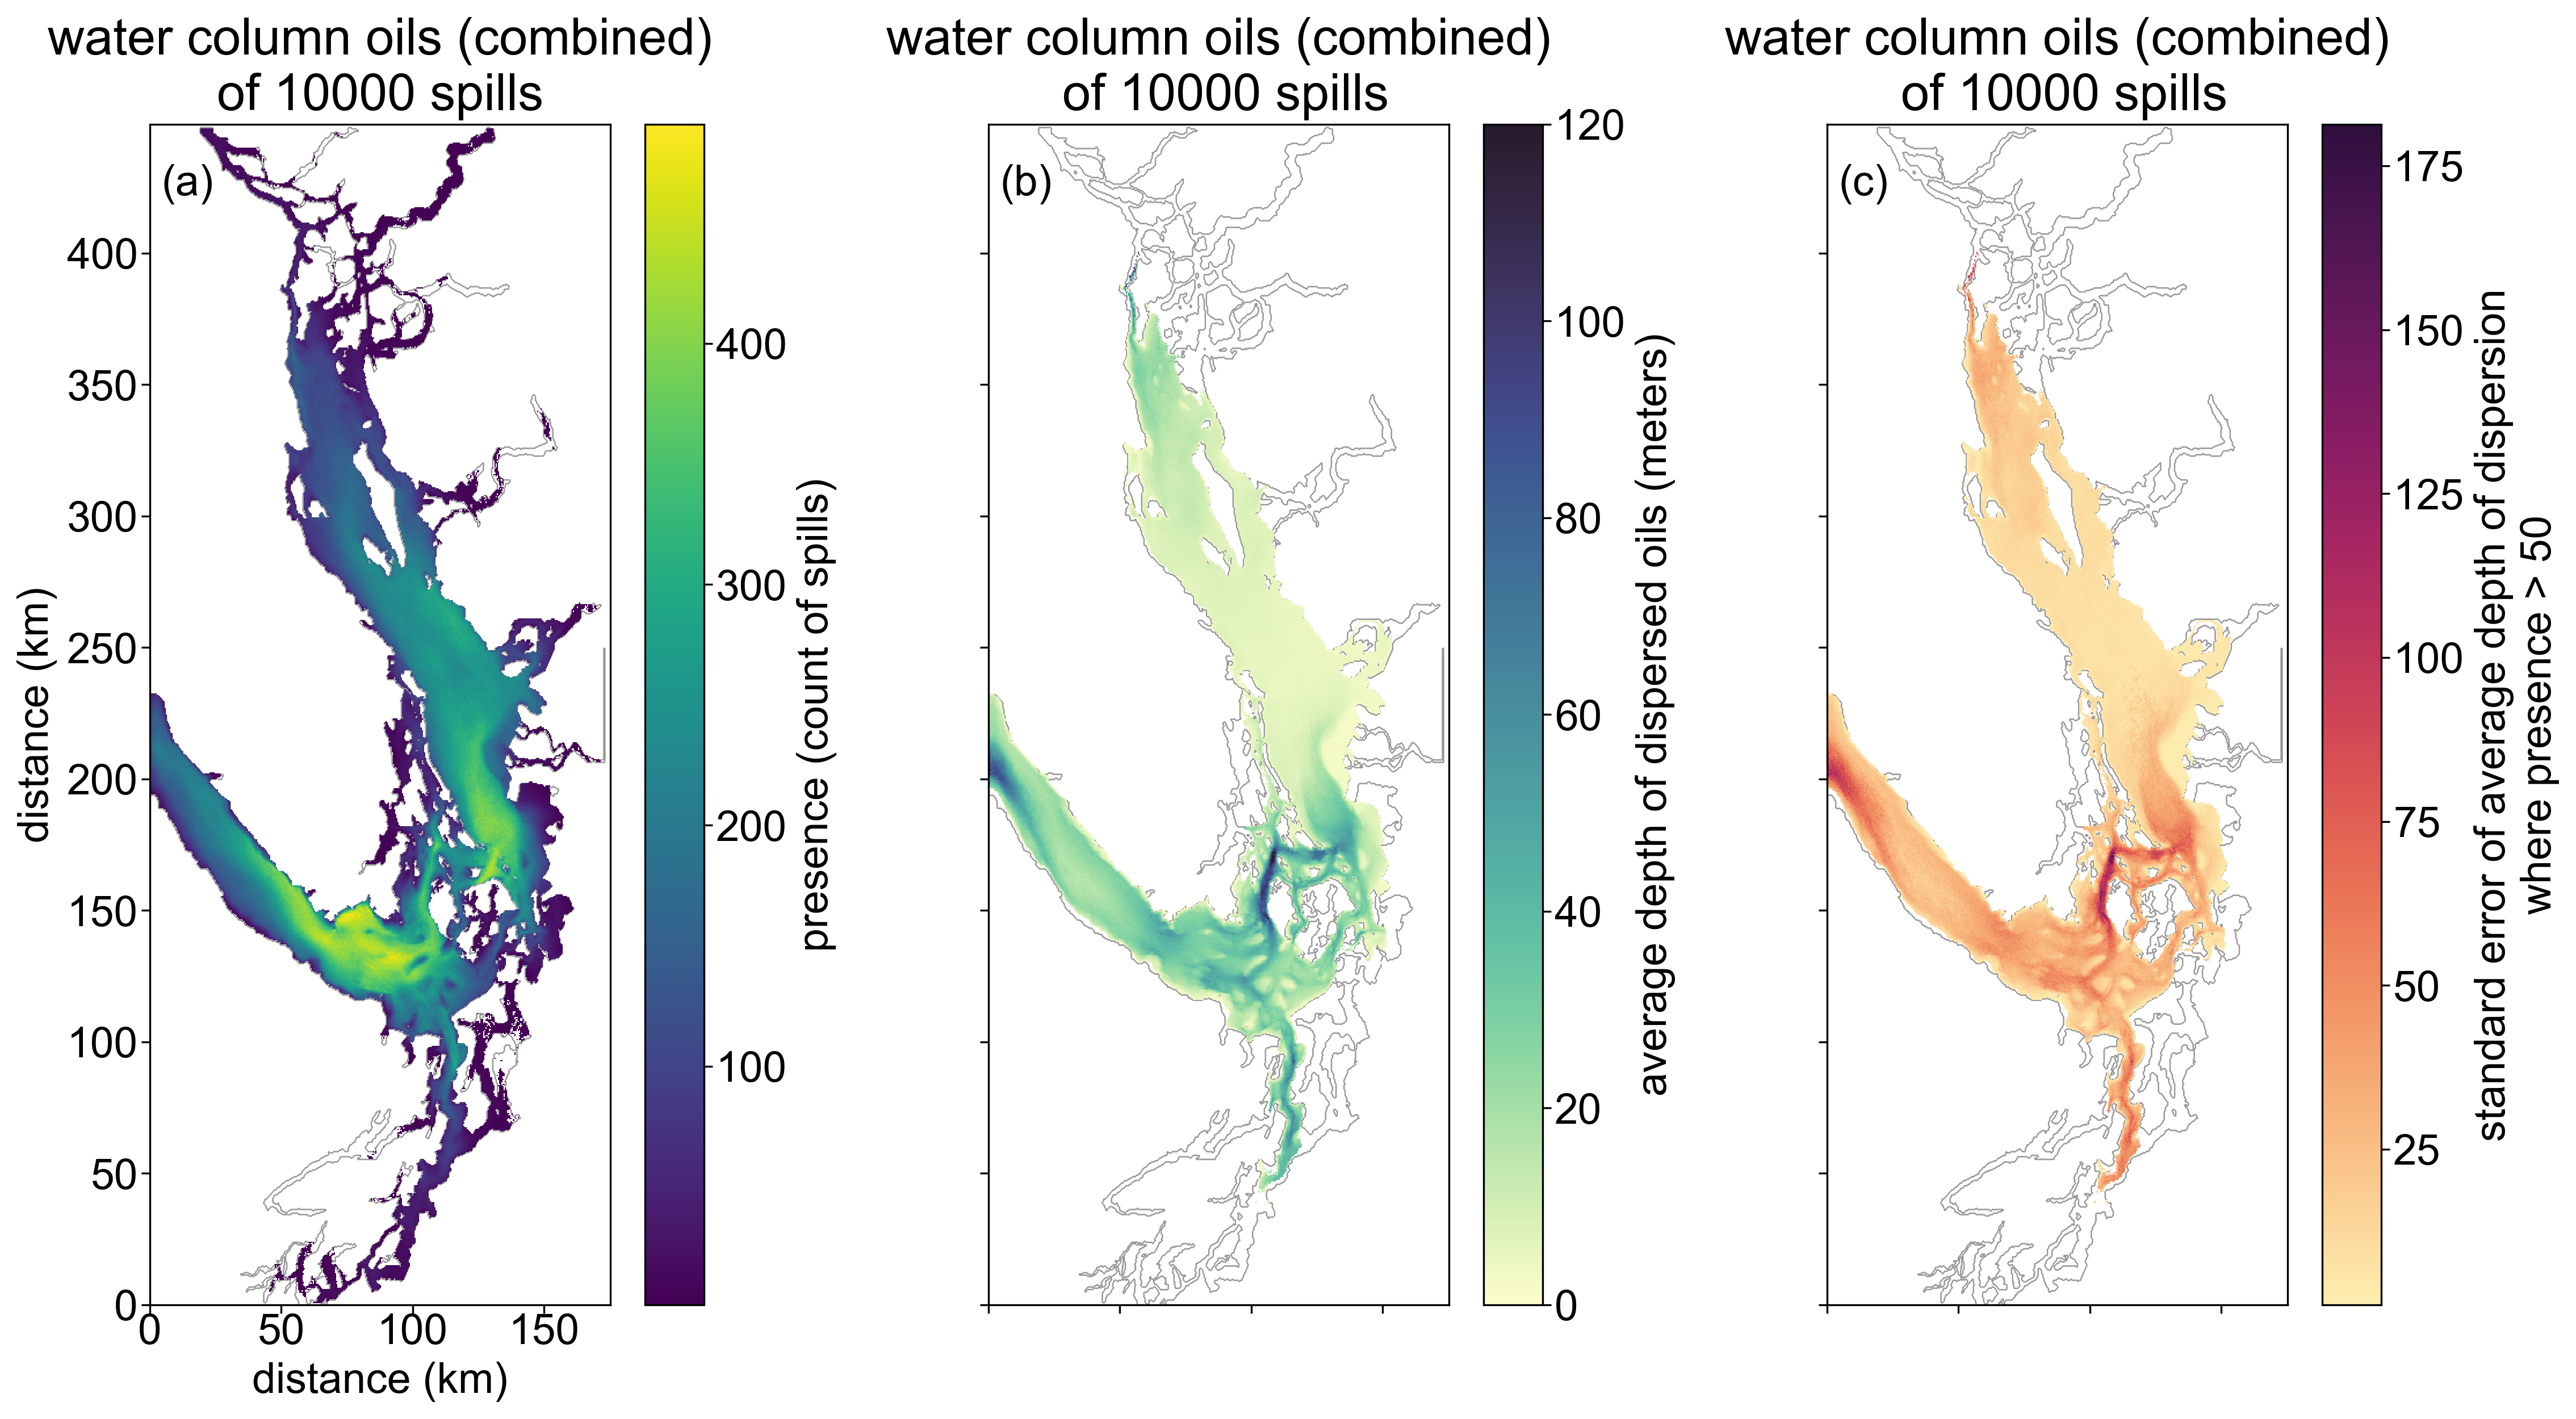

In [11]:
fig, axs = plt.subplots(
    1, 3, 
    figsize=(18, 9), 
    gridspec_kw={'hspace': 0.0}
)

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    #ax.pcolormesh(tmask[1:, 1:], color='papayawhip', vmin=.1, vmax=.8)
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    # dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
    
C = axs[0].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title(f'water column oils (combined)\nof {oil.nofiles.values+smalloils} spills');   

C = axs[1].pcolormesh(
     ma_deep_location,
    zorder=2, vmin=0, vmax=120, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('average depth of dispersed oils (meters)')
axs[1].set_title(f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');

C = axs[2].pcolormesh(
     ma_location_ste_2,
    zorder=2, cmap=cm.matter
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('standard error of average depth of dispersion\nwhere presence > 50')
axs[2].set_title(f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');

# add suplot labels
subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig('../../Publications/MIDOSS_MuellerEtAl/graphics/Figure11_watercol_presence.png')